In [151]:
import torch
import numpy as np
from scipy.signal import fftconvolve
import torchaudio

In [152]:
import import_ipynb
from model import CRN_2
from dataset import Dataset

In [153]:
ANC = CRN_2()
ANC.load_state_dict(torch.load('7th_ELU.pth'))

<All keys matched successfully>

In [154]:
def rir( wav: torch.Tensor, rir_path: str) -> torch.Tensor:
        rir_np = np.loadtxt(rir_path)[:, 1]
        rir_energy = np.sum(rir_np**2)
        rir_np = rir_np / np.sqrt(rir_energy)
        rir_tensor = torch.from_numpy(rir_np).float()
        wav_np = wav.cpu().numpy()
        rir_np = rir_tensor.cpu().numpy()
        y_np = fftconvolve(wav_np, rir_np, mode="full")
        y = torch.from_numpy(y_np).float()
        #print(y.shape) # 19199
        return y[0:80000]

In [155]:
data = Dataset(train=False)
x,y = data[0]

In [157]:
def test(ori,model):
    model.eval()
    perr = rir(ori, "p-err.txt")
    n_fft = 320
    hop_length = 160
    win_length = 320
    window = torch.hann_window(win_length)
    ori = ori.unsqueeze(0)
    with torch.no_grad():
        stft_ori = torch.stft(
            ori, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
            return_complex=True, center=True, onesided=True, window=window
        )
        stft_ori_real = stft_ori.real
        stft_ori_imag = stft_ori.imag
        stft_x_tensor = torch.stack([stft_ori_real, stft_ori_imag], dim=1)
        stft_pred = model(stft_x_tensor)
        stft_pred_complex = torch.complex(stft_pred[:, 0], stft_pred[:, 1])
        # ISTFT
        istft_pred = torch.istft(
            stft_pred_complex,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            center=True,
            onesided=True,
            window=window,
            length=ori.shape[1]
        )
        istft_pred = istft_pred.squeeze(0)
        u_serr = rir(istft_pred,"s-err.txt")
        error  = perr + u_serr
    return ori.squeeze(0),perr,u_serr,error

In [ ]:
ori,perr,u_serr,error = test(x,ANC) #original, primary-path, antinoise-only, error 

In [159]:
# 채널 추가 (1D → [1, N])
torchaudio.save("original.wav", ori.unsqueeze(0), 16000)
torchaudio.save("primary_error.wav", perr.unsqueeze(0), 16000)
torchaudio.save("anti-noise.wav", u_serr.unsqueeze(0), 16000)
torchaudio.save("final-error.wav", error.unsqueeze(0), 16000)

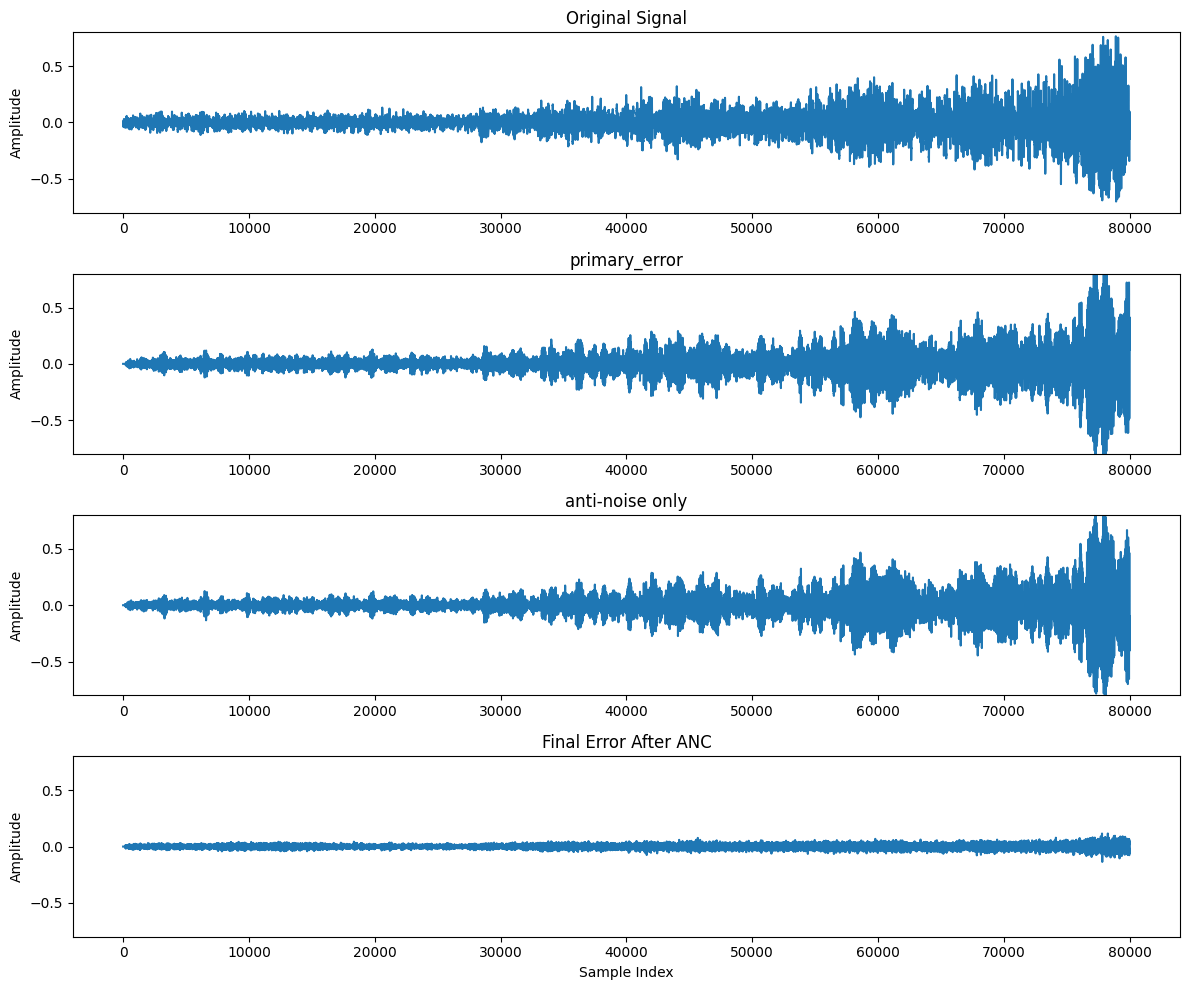

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# y축 범위 통일
ylim = (-0.8, 0.8)

# 1. ori
plt.subplot(4, 1, 1)
plt.plot(ori)
plt.title("Original Signal")
plt.ylabel("Amplitude")
plt.ylim(ylim)

# 2. perr
plt.subplot(4, 1, 2)
plt.plot(perr)
plt.title("primary_error")
plt.ylabel("Amplitude")
plt.ylim(ylim)

# 3. u_serr
plt.subplot(4, 1, 3)
plt.plot(u_serr)
plt.title("anti-noise only")
plt.ylabel("Amplitude")
plt.ylim(ylim)

# 4. error
plt.subplot(4, 1, 4)
plt.plot(error)
plt.title("Final Error After ANC")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.ylim(ylim)

plt.tight_layout()
plt.show()

